In [1]:
## Librairies

from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import copy
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import IMDB

In [35]:
## Paramètres

MAX_SEQ_LEN = 512
LENGTH_BATCH=20
BATCH_SIZE=10
# BATCH_SIZE=1
epochs=50
lr=0.01

model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
## Base de données

Input = IMDB(split='train')
Input=list(Input)[500:500+LENGTH_BATCH]

Input_sentences=[]
for label, line in Input:
    Input_sentences.append(line)

Input_sentences

['When I ordered this from Blockbuster\'s website I had no idea that it would be as terrible as it was. Who knows? Maybe I\'d forgotten to take my ADD meds that day. I do know that from the moment the cast drove up in their station wagon, donned in their late 70\'s-style wide collars, bell-bottoms and feathered hair, I knew that this misplaced gem of the disco era was glory bound for the dumpster.<br /><br />The first foretelling of just how bad things were to be was the narration at the beginning, trying to explain what cosmic forces were at play to wreak havoc upon the universe, forcing polyester and porno-quality music on the would-be viewer. From the opening scene with the poorly-done effects to the "monsters" from another world and then the house which jumps from universe to universe was as achingly painful as watching an elementary school production of \'The Vagina Monologues\'.<br /><br />Throughout the film, the sure sign something was about to happen was when a small ship woul

In [37]:
## Tokeniser + Masques 


Input_tokenised=tokenizer.batch_encode_plus(Input_sentences,return_tensors="pt",padding="max_length", max_length=MAX_SEQ_LEN, truncation=True)
Input_tokenised_new=copy.deepcopy(Input_tokenised)


Mask_indices=[]

for i in range (len(Input_tokenised["input_ids"])):
    L_indice=np.zeros_like(Input_tokenised["input_ids"][i])
    for proba in range (int(0.15 * float(Input_tokenised["input_ids"][i].tolist().index(102)))):
        mask_indice=random.randrange(start=1, stop=Input_tokenised["input_ids"][i].tolist().index(102)-1)
        Input_tokenised_new["input_ids"][i][mask_indice]=103
        L_indice[mask_indice]=1
    Mask_indices.append(L_indice)

Tensor_Mask_indices=torch.tensor(np.array(Mask_indices))

In [38]:
## Logits de Bert

with torch.no_grad():
    Bert_logits=model(**Input_tokenised).logits

In [40]:
## Fonctions utiles


# Création Matrice Pseudo-Attention (pour contexte)
def matrice_pseudo_attention_cbow(weight,L_size):
    att=np.c_[np.zeros(L_size) ,weight*np.identity(L_size)[:,:-1] ] + weight*np.identity(L_size) + weight*np.c_[np.identity(L_size)[:,1:], np.zeros(L_size) ] 
    # Traiter cas windowsize pair (rajouter une Identité sur la droite)
    return(torch.from_numpy(att))


# Calcul de l'accuracy
def accuracy_score(Y_model,verite_terrain):
    score=0
    for i in range (len(Y_model)): #pour chaque mot masqué
        y_top_5=(-Y_model[i]).argsort()[:5]  #les mots les plus probables selon Y
        if verite_terrain[i] in y_top_5:
            score+=1
    return(score/len(Y_model))

In [41]:
## Modèle

class MLM(nn.Module):
    def __init__(self,bert):
        super(MLM, self).__init__()

        self.embedding= nn.Embedding(30522,768)

        self.v = nn.Linear(768, 30522,bias = False)

        self.v.weight = torch.nn.Parameter(model.bert.embeddings.word_embeddings.weight,requires_grad=True)

        #trouver comment faire du parameter sharing

    def forward(self, tokens):
        emb_init = self.embedding(tokens) #Premiere représentation des tokens
        A=matrice_pseudo_attention_cbow(1,emb_init.shape[1])
        emb_init_context=torch.matmul(A.float(),emb_init)
    
        return self.v(emb_init_context)


## Création du modèle (avec paramètres)

cbow=MLM(model)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(cbow.parameters(), lr )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [42]:
## Batchs des données 

class TextDataset(Dataset):

    def __init__(self, X, M, Y_bert, torch_verite_terrain):
        self.inputs = X
        self.masques = M
        self.targets = Y_bert
        self.verite_terrain=torch_verite_terrain

    def __len__(self):
        return len(self.targets)

    def Y_bert(self,ind):
        return(self.targets[ind].squeeze())
    
    def __getitem__(self, index):
        return (self.inputs[index],self.masques[index],self.targets[index],self.verite_terrain[index])
    

#Création du batch

data= TextDataset( 
    Input_tokenised_new["input_ids"],
    Tensor_Mask_indices,
    Bert_logits,
   Input_tokenised["input_ids"]
)

train_loader = DataLoader(data,batch_size=BATCH_SIZE,shuffle=False)

In [45]:
## Training

losses=[]
score=0
total_accuracy=[]

for epoch in tqdm(range(epochs)):

    total_loss = 0  

    for batch in (train_loader):

        X,M,Y_bert,verite_terrain = batch

        cbow.zero_grad()
        
        Y_model=cbow(X)

        loss=loss_function(Y_model[M==1],Y_bert[M==1])

        score=accuracy_score(Y_model[M==1],verite_terrain[M==1])
        
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        losses.append(total_loss)
    total_accuracy.append(score)

 36%|███▌      | 18/50 [05:40<09:49, 18.42s/it]

In [ ]:
print("Precision finale de " + str(round(score*100.,2)) + "% ")

Precision finale de 11.02% 


In [ ]:
## Création du dossier de sauvegarde

Nom='CBOW_initial'

Dossier=os.path.join('Saves/',Nom)
if not os.path.exists(Dossier):
    os.makedirs(Dossier)
print(Dossier)

Saves/CBOW_initial


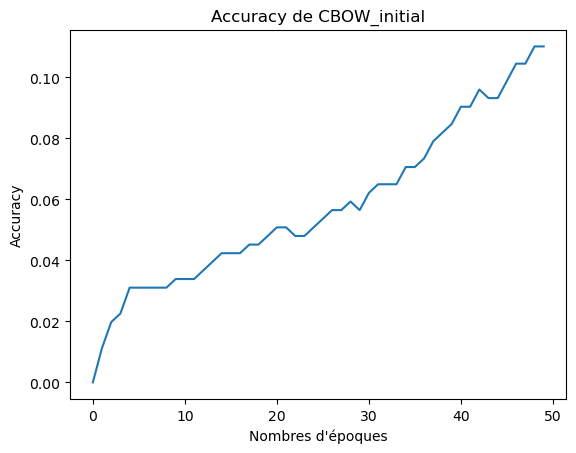

In [ ]:
## Evolution de l'accuracy train

plt.figure()
plt.plot(total_accuracy)
plt.title('Accuracy de ' + str(Nom))
plt.xlabel("Nombres d'époques")
plt.ylabel("Accuracy")
plt.savefig(Dossier + "Accuracy" + str(Nom) + ".png")

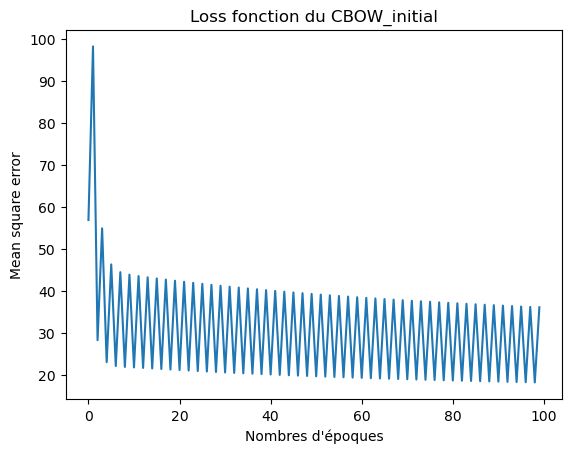

In [ ]:
## Evolution de la fonction de cout

plt.figure()
plt.plot(losses)
plt.title('Loss fonction du ' + str(Nom))
plt.xlabel("Nombres d'époques")
plt.ylabel("Mean square error")
plt.savefig(Dossier + "LossFonction" + str(Nom) + ".png")

In [ ]:
## Sauvegardes des paramètres 

nbr_parameters= sum([np.prod(p.size()) for p in cbow.parameters()])

parameters=np.array([[nbr_parameters],
                     [ str(round(score*100.,2)) + "% "],
                    [epochs],
                    [lr]])

lignes_param = ['Nombres de Paramètres: ', 'accuracy','Epoques: ','Learning rate: ']

param_df = pd.DataFrame(data = parameters,index = lignes_param)

param_df.to_csv(Dossier + '/Paramètres' +str(Nom)  + '.csv',sep =';')


46881792
